In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import itertools
import random
random.seed(108448)
from scipy.stats import poisson

#%pip install gurobipy
import gurobipy as gp
from gurobipy import GRB

Data generation

In [16]:
#Define the number of elements in each set I, J, K
i_num = 25
k_num = 3
j_num = 500 #Without I and K, so real j_num_real = j_num + i_num + k_num

#Define empty data frames
I = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longitude'])
J = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longitude'])
K = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longitude'])


In [17]:
#Define sets of I, J, K, where J contains I and K

for i in range(i_num):
    I.loc[i, 'Point number'] = 'i'+ str(i)
    I.loc[i, 'Latitude'] = round(random.uniform(0, 50), 4)
    I.loc[i, 'Longitude'] = round(random.uniform(0, 50), 4)

I.index = I['Point number']
    
    
for k in range(k_num):
    K.loc[k, 'Point number'] = 'k'+ str(k)
    K.loc[k, 'Latitude'] = round(random.uniform(0, 50), 4)
    K.loc[k, 'Longitude'] = round(random.uniform(0, 50), 4)

K.index = K['Point number']


for j in range(j_num):
    J.loc[j, 'Point number'] = 'j'+ str(j)
    J.loc[j, 'Latitude'] = round(random.uniform(0, 50), 4)
    J.loc[j, 'Longitude'] = round(random.uniform(0, 50), 4)

J.index = J['Point number'] 
J = pd.concat([J, K, I], axis = 0) #Include K to J
I.index

Index(['i0', 'i1', 'i2', 'i3', 'i4', 'i5', 'i6', 'i7', 'i8', 'i9', 'i10',
       'i11', 'i12', 'i13', 'i14', 'i15', 'i16', 'i17', 'i18', 'i19', 'i20',
       'i21', 'i22', 'i23', 'i24'],
      dtype='object', name='Point number')

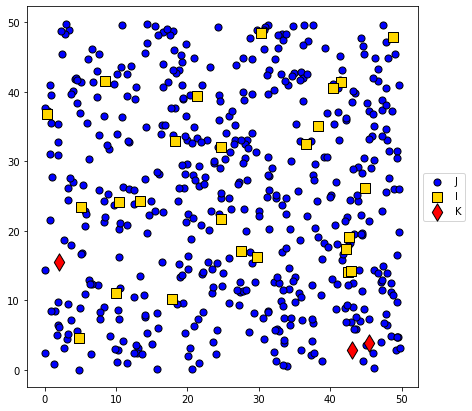

In [18]:
axs, fig = plt.subplots(1, 1, figsize = (7, 7))

fig.scatter(J['Latitude'], J['Longitude'], color = 'blue', edgecolors = 'black',
            marker = 'o', s = 50, label = 'J')
fig.scatter(I['Latitude'], I['Longitude'], color = 'gold', edgecolors = 'black',
            marker = 's', s = 100, label = 'I')
fig.scatter(K['Latitude'], K['Longitude'], color = 'red', edgecolors = 'black',
            marker = 'd', s = 150, label = 'K')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [19]:
# from pathlib import Path
# import pandas as pd
# import geopandas as gpd
# import shapely
# #%pip install folium matplotlib mapclassify
# import folium
# import matplotlib

# # Doctor's coordinates
# doctors = {'Latitude' : [48.56500199216254, 48.5705, 48.575], 'Longitude' : [13.433214775837387, 13.436, 13.44]}
# df = pd.DataFrame(doctors)
# df

# # create geodataframe, NB CRS
# geo_df = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df["Latitude"], df["Longitude"]), crs="epsg:4386")


# with open('Polygon Passau.txt', 'r') as file:
#     # Read the contents of the file into a string
#     polygon_str = file.read()

# # Now file_contents contains the contents of the file as a string
# passau_poly = shapely.wkt.loads(polygon_str)


# passau_gdf = gpd.GeoDataFrame(geometry=[passau_poly], crs="epsg:4326")
# passau_map = folium.Map(location=[48.565, 13.433], zoom_start=12)
# folium.GeoJson(passau_gdf).add_to(passau_map)

# geo_doctors = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df["Latitude"], df["Longitude"]), crs="epsg:4326")

# for idx, row in geo_doctors.iterrows():
#     folium.Marker([row['Latitude'], row['Longitude']], icon=folium.Icon(icon='circle', prefix='fa', color='blue'), 
#                   icon_size=(0.5, 0.5)).add_to(passau_map)

# lines = []
# for i in range(len(geo_doctors) - 1):
#     point1 = geo_doctors.iloc[i].geometry
#     point2 = geo_doctors.iloc[i + 1].geometry
#     lines.append([point1.coords[0], point2.coords[0]])

# folium.PolyLine(lines, color='blue').add_to(passau_map)



# passau_map

In [20]:
#Define constants

B = 100
S = 10
alpha = 10

beta = {}
for j in J.index:
    if j.startswith('j'):
        beta[j] = 400
    else:
        beta[j] = 300
        
gamma = 0.05
        
q_j = {j: 50 for j in J.index}

up_bound = 12
mu = {i : int(round(random.uniform(0, up_bound), 0)) for i in I.index}

mu

{'i0': 8,
 'i1': 8,
 'i2': 8,
 'i3': 9,
 'i4': 1,
 'i5': 11,
 'i6': 4,
 'i7': 5,
 'i8': 9,
 'i9': 11,
 'i10': 5,
 'i11': 9,
 'i12': 9,
 'i13': 8,
 'i14': 4,
 'i15': 5,
 'i16': 9,
 'i17': 4,
 'i18': 3,
 'i19': 6,
 'i20': 7,
 'i21': 4,
 'i22': 6,
 'i23': 10,
 'i24': 9}

Deterministic model

In [21]:
theta_det = {}
for n in I.index:
    theta_det[n] = list(poisson.rvs(mu[n], size = 1))[0]
theta_det

{'i0': 14,
 'i1': 9,
 'i2': 5,
 'i3': 5,
 'i4': 2,
 'i5': 10,
 'i6': 6,
 'i7': 7,
 'i8': 8,
 'i9': 11,
 'i10': 7,
 'i11': 4,
 'i12': 2,
 'i13': 7,
 'i14': 2,
 'i15': 3,
 'i16': 7,
 'i17': 1,
 'i18': 4,
 'i19': 9,
 'i20': 8,
 'i21': 6,
 'i22': 9,
 'i23': 8,
 'i24': 8}

In [22]:
#Define distance matrices

def distance(point1, PointsSet1, point2, PointsSet2):
    c1 = np.array((PointsSet1.loc[point1, 'Latitude'], PointsSet1.loc[point1, 'Longitude']))
    c2 = np.array((PointsSet2.loc[point2, 'Latitude'], PointsSet2.loc[point2, 'Longitude']))
    return np.linalg.norm(c1-c2)

dist_JI = {(c1, c2): distance(c1, J, c2, I)for c1, c2 in itertools.product(J.index, I.index)}
dist_IK = {(c1, c2): distance(c1, I, c2, K)for c1, c2 in itertools.product(I.index, K.index)}
dist_KJ = {(c1, c2): distance(c1, K, c2, J)for c1, c2 in itertools.product(K.index, J.index)}
 
dist_KJ


{('k0', 'j0'): 31.632567769942423,
 ('k0', 'j1'): 37.167742363506555,
 ('k0', 'j2'): 9.301695681971111,
 ('k0', 'j3'): 43.19813842296911,
 ('k0', 'j4'): 24.243158540297507,
 ('k0', 'j5'): 37.22434439691315,
 ('k0', 'j6'): 35.53607135644006,
 ('k0', 'j7'): 32.637745853535904,
 ('k0', 'j8'): 20.36197838423369,
 ('k0', 'j9'): 12.963893478426922,
 ('k0', 'j10'): 44.910354104593736,
 ('k0', 'j11'): 43.789715439244404,
 ('k0', 'j12'): 21.89126300719079,
 ('k0', 'j13'): 30.153330299819288,
 ('k0', 'j14'): 9.049538212527754,
 ('k0', 'j15'): 47.19626592962625,
 ('k0', 'j16'): 45.30118846167283,
 ('k0', 'j17'): 33.41686919925324,
 ('k0', 'j18'): 45.92884344222048,
 ('k0', 'j19'): 8.552067035518371,
 ('k0', 'j20'): 32.16994078981185,
 ('k0', 'j21'): 39.58752696809944,
 ('k0', 'j22'): 22.460049732803355,
 ('k0', 'j23'): 36.10793115494157,
 ('k0', 'j24'): 23.00296596637051,
 ('k0', 'j25'): 15.5044490505145,
 ('k0', 'j26'): 28.872165170108044,
 ('k0', 'j27'): 45.077355528690894,
 ('k0', 'j28'): 54.0

In [23]:
#Define set L
L = list()
for k, j in itertools.product(K.index, J.index):
    if dist_KJ[(k, j)] <= 0.5*B:
        L.append((k, j))
        
L

[('k0', 'j0'),
 ('k0', 'j1'),
 ('k0', 'j2'),
 ('k0', 'j3'),
 ('k0', 'j4'),
 ('k0', 'j5'),
 ('k0', 'j6'),
 ('k0', 'j7'),
 ('k0', 'j8'),
 ('k0', 'j9'),
 ('k0', 'j10'),
 ('k0', 'j11'),
 ('k0', 'j12'),
 ('k0', 'j13'),
 ('k0', 'j14'),
 ('k0', 'j15'),
 ('k0', 'j16'),
 ('k0', 'j17'),
 ('k0', 'j18'),
 ('k0', 'j19'),
 ('k0', 'j20'),
 ('k0', 'j21'),
 ('k0', 'j22'),
 ('k0', 'j23'),
 ('k0', 'j24'),
 ('k0', 'j25'),
 ('k0', 'j26'),
 ('k0', 'j27'),
 ('k0', 'j29'),
 ('k0', 'j30'),
 ('k0', 'j31'),
 ('k0', 'j32'),
 ('k0', 'j33'),
 ('k0', 'j34'),
 ('k0', 'j35'),
 ('k0', 'j36'),
 ('k0', 'j37'),
 ('k0', 'j38'),
 ('k0', 'j39'),
 ('k0', 'j40'),
 ('k0', 'j41'),
 ('k0', 'j42'),
 ('k0', 'j43'),
 ('k0', 'j44'),
 ('k0', 'j45'),
 ('k0', 'j47'),
 ('k0', 'j48'),
 ('k0', 'j49'),
 ('k0', 'j50'),
 ('k0', 'j51'),
 ('k0', 'j52'),
 ('k0', 'j53'),
 ('k0', 'j55'),
 ('k0', 'j56'),
 ('k0', 'j57'),
 ('k0', 'j58'),
 ('k0', 'j59'),
 ('k0', 'j60'),
 ('k0', 'j61'),
 ('k0', 'j62'),
 ('k0', 'j63'),
 ('k0', 'j64'),
 ('k0', 'j65'),
 (

In [24]:
#Define sets M_kj

M_kj = {}
M_interim = []

for (k, j) in L:
    for i in I.index:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] + dist_KJ[k, j] <= B:
                M_interim.append(i)
    M_kj[(k, j)] = M_interim
    M_interim = []

M_kj_interim = {key : val for key, val in M_kj.items() if val != []}  

KJ_feas = list(M_kj_interim.keys())
KJ_feas


[('k0', 'j0'),
 ('k0', 'j2'),
 ('k0', 'j3'),
 ('k0', 'j4'),
 ('k0', 'j5'),
 ('k0', 'j6'),
 ('k0', 'j7'),
 ('k0', 'j8'),
 ('k0', 'j9'),
 ('k0', 'j10'),
 ('k0', 'j11'),
 ('k0', 'j12'),
 ('k0', 'j13'),
 ('k0', 'j14'),
 ('k0', 'j15'),
 ('k0', 'j16'),
 ('k0', 'j17'),
 ('k0', 'j19'),
 ('k0', 'j20'),
 ('k0', 'j21'),
 ('k0', 'j22'),
 ('k0', 'j23'),
 ('k0', 'j24'),
 ('k0', 'j25'),
 ('k0', 'j26'),
 ('k0', 'j27'),
 ('k0', 'j29'),
 ('k0', 'j30'),
 ('k0', 'j31'),
 ('k0', 'j32'),
 ('k0', 'j33'),
 ('k0', 'j34'),
 ('k0', 'j35'),
 ('k0', 'j36'),
 ('k0', 'j37'),
 ('k0', 'j38'),
 ('k0', 'j39'),
 ('k0', 'j40'),
 ('k0', 'j41'),
 ('k0', 'j42'),
 ('k0', 'j43'),
 ('k0', 'j44'),
 ('k0', 'j45'),
 ('k0', 'j47'),
 ('k0', 'j48'),
 ('k0', 'j49'),
 ('k0', 'j51'),
 ('k0', 'j53'),
 ('k0', 'j55'),
 ('k0', 'j56'),
 ('k0', 'j57'),
 ('k0', 'j58'),
 ('k0', 'j59'),
 ('k0', 'j60'),
 ('k0', 'j61'),
 ('k0', 'j62'),
 ('k0', 'j63'),
 ('k0', 'j64'),
 ('k0', 'j65'),
 ('k0', 'j66'),
 ('k0', 'j67'),
 ('k0', 'j68'),
 ('k0', 'j70'),
 

In [25]:
#Define sets N_i

N_i = {}
N_interim = []

for i in I.index:
    for (k, j) in L:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] + dist_KJ[k, j] <= B:
                N_interim.append((k, j))
    N_i[i] = N_interim
    N_interim = []
    
N_i_interim = {key : val for key, val in N_i.items() if val != []}   
 
I_feas = list(N_i_interim.keys())

In [26]:
model_det = gp.Model('Deterministic model')

x_ikj = model_det.addVars(I.index, L, vtype = GRB.INTEGER, name = 'x_ikj')
y_j = model_det.addVars(J.index, vtype = GRB.BINARY, name = 'y_j')

In [27]:
model_det.addConstrs((gp.quicksum(x_ikj[i, k, j] for (k, j) in N_i[i]) >= theta_det[i] for i in I_feas), name = 'c2')
model_det.addConstrs((gp.quicksum(x_ikj[i, k, j] for i in M_kj[(k, j)]) <= q_j[j] * y_j[j] for (k, j) in KJ_feas), name = 'c4')
model_det.addConstrs(((dist_JI[(j, i)] + dist_IK[(i, k)] + dist_KJ[(k, j)]) * y_j[j] <= B
                  for (k, j) in N_i[i] for i in M_kj[(k, j)]), name = 'c5')
model_det.addConstrs((dist_JI[(j, i)] * y_j[j] <= S for (k, j) in N_i[i] for i in M_kj[(k, j)]), name = 'c6')

{('k0', 'j33', 'i10'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j33', 'i16'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j33', 'i24'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j41', 'i9'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j41', 'i17'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j41', 'i24'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j61', 'i15'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j61', 'i16'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j61', 'i22'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j61', 'i24'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j65', 'i15'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j65', 'i16'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j65', 'i22'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j65', 'i24'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j66', 'i10'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j66', 'i16'): <gurobi.Constr *Aw

In [28]:
model_det.setObjective(alpha * gp.quicksum(x_ikj[i, k, j] for i in I.index for (k, j) in L) + gp.quicksum(beta[j] * y_j[j] for j in J.index))
                       #+ gamma * gp.quicksum( * y_j[j] for j in J.index), GRB.MINIMIZE)
model_det.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2859 rows, 37303 columns and 11196 nonzeros
Model fingerprint: 0xd9ddb785
Variable types: 0 continuous, 37303 integer (528 binary)
Coefficient statistics:
  Matrix range     [4e-01, 1e+02]
  Objective range  [1e+01, 4e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective 11220.000000
Presolve removed 1476 rows and 32626 columns
Presolve time: 0.06s
Presolved: 1383 rows, 4677 columns, 9732 nonzeros
Variable types: 0 continuous, 4677 integer (637 binary)

Root relaxation: objective 2.242749e+03, 3330 iterations, 0.05 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/No

In [29]:
def ListSolution(model):
        nSolutions = model.SolCount
        print('Number of solutions found: ' + str(nSolutions))
        for e in range(nSolutions):
        #for iter2 in range(1):
                model.setParam(GRB.Param.SolutionNumber, e)
                print(e)
                print('%g ' % model.PoolObjVal, end='\n')
                for v in model.getVars():
                        if v.X > 0:
                                print ('%s %g' % (v.varName, v.X))
                                #print(v)
                print("\n")
                
        print("\n")
        
ListSolution(model_det)

Number of solutions found: 6
0
3720 
x_ikj[i0,k2,i0] 14
x_ikj[i1,k0,j319] 9
x_ikj[i2,k1,j407] 5
x_ikj[i3,k1,j319] 5
x_ikj[i4,k1,i0] 2
x_ikj[i5,k0,i12] 10
x_ikj[i6,k0,i6] 6
x_ikj[i7,k1,j182] 3
x_ikj[i7,k2,j182] 4
x_ikj[i8,k0,j407] 8
x_ikj[i9,k0,j407] 11
x_ikj[i10,k0,j182] 7
x_ikj[i11,k1,j319] 4
x_ikj[i12,k0,i12] 2
x_ikj[i13,k2,i12] 7
x_ikj[i14,k2,i12] 2
x_ikj[i15,k1,j319] 3
x_ikj[i16,k0,j182] 2
x_ikj[i16,k1,j182] 5
x_ikj[i17,k2,j407] 1
x_ikj[i18,k1,i6] 4
x_ikj[i19,k0,i6] 9
x_ikj[i20,k2,i0] 8
x_ikj[i21,k0,i0] 6
x_ikj[i22,k2,j407] 9
x_ikj[i23,k1,i0] 8
x_ikj[i24,k1,j407] 8
y_j[j182] 1
y_j[j319] 1
y_j[j407] 1
y_j[i0] 1
y_j[i6] 1
y_j[i12] 1


1
4020 
x_ikj[i0,k2,i0] 14
x_ikj[i1,k0,j319] 9
x_ikj[i2,k1,j407] 5
x_ikj[i3,k1,j319] 5
x_ikj[i4,k1,i0] 2
x_ikj[i5,k0,i12] 10
x_ikj[i6,k0,i6] 6
x_ikj[i7,k1,j182] 3
x_ikj[i7,k2,j182] 4
x_ikj[i8,k0,j407] 8
x_ikj[i9,k0,j407] 11
x_ikj[i10,k0,j182] 7
x_ikj[i11,k1,j319] 4
x_ikj[i12,k0,i12] 2
x_ikj[i13,k2,i12] 7
x_ikj[i14,k2,i12] 2
x_ikj[i15,k1,j319] 3
x_ikj[i1

In [30]:
def SolutionSummary(model):
    n = -1
    results = pd.DataFrame(columns = ['i', 'k', 'j', 'Number of drones'])
    for opt_sol in range(1):
        for v in model.getVars():
            if v.varName.startswith('x_ikj'):
                if v.X > 0:
                    n += 1
                    indices = v.varName[6:-1].split(',') #drop variable name and brackets and convert to a list of indices
                    results.loc[n, 'i'] = indices[0]
                    results.loc[n, 'k'] = indices[1]
                    results.loc[n, 'j'] = indices[2]
                    results.loc[n, 'Number of drones'] = int(v.X)
    results_doctors = results.groupby('i', as_index = False)['Number of drones'].sum()
    results_locations = results.groupby('j', as_index = False)['Number of drones'].sum()
    return results_doctors, results_locations

SolutionSummary(model_det)

(      i  Number of drones
 0    i0                14
 1    i1                 9
 2   i10                 7
 3   i11                 4
 4   i12                 2
 5   i13                 7
 6   i14                 2
 7   i15                 3
 8   i16                 7
 9   i17                 1
 10  i18                 4
 11  i19                 9
 12   i2                 5
 13  i20                 8
 14  i21                 6
 15  i22                 9
 16  i23                 8
 17  i24                 8
 18   i3                 5
 19   i4                 2
 20   i5                10
 21   i6                 6
 22   i7                 7
 23   i8                 8
 24   i9                11,
       j  Number of drones
 0    i0                38
 1   i12                21
 2    i6                19
 3  j182                21
 4  j319                21
 5  j407                42)

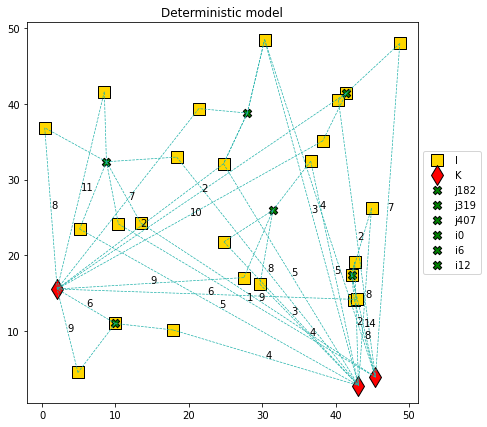

In [31]:
def SolutionGraph(I, K, J, model):
        
        axs, fig = plt.subplots(1, 1, figsize = (7, 7))
                
        fig.scatter(I['Latitude'], I['Longitude'], color = 'gold', edgecolors = 'black',
                                marker = 's', s = 150, label = 'I')
        fig.scatter(K['Latitude'], K['Longitude'], color = 'red', edgecolors = 'black',
                                marker = 'd', s = 200, label = 'K')
        
        fig.set_title(model.ModelName)
        model.setParam(GRB.Param.SolutionNumber, 0)
        for v in model.getVars():
                if v.xn > 0:
                        if v.varName.startswith('x_ikj'):
                                indices_x = v.varName[6:-1].split(',') #drop variable name and brackets and convert to a list of indices
                                fig.plot((J.loc[indices_x[2], 'Latitude'], I.loc[indices_x[0], 'Latitude']),
                                        (J.loc[indices_x[2], 'Longitude'], I.loc[indices_x[0], 'Longitude']),
                                        color = 'lightseagreen', linestyle = "--", linewidth = 0.7)
                                fig.plot((I.loc[indices_x[0], 'Latitude'], K.loc[indices_x[1], 'Latitude']),
                                        (I.loc[indices_x[0], 'Longitude'], K.loc[indices_x[1], 'Longitude']),
                                        color = 'lightseagreen', linestyle = "--", linewidth = 0.7)
                                fig.annotate(str(int(v.xn)), xy = ((K.loc[indices_x[1], 'Latitude'] + I.loc[indices_x[0], 'Latitude'])/2,
                                                                (K.loc[indices_x[1], 'Longitude'] + I.loc[indices_x[0], 'Longitude'])/2))
                                #fig.annotate(str(int(v.xn)), xy = ((J.loc[indices_x[2], 'Latitude'] + I.loc[indices_x[0], 'Latitude'])/2,
                                                                #(J.loc[indices_x[2], 'Longitude'] + I.loc[indices_x[0], 'Longitude'])/2))
                        else:
                                index_y = v.varName[4:-1]
                                fig.scatter(J.loc[index_y, 'Latitude'], J.loc[index_y, 'Longitude'], color = 'green',
                                        edgecolors = 'black', s = 70, marker = 'X', label = index_y)
                fig.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))
    

SolutionGraph(I, K, J, model_det)

In [32]:
for v in model_det.getVars():
        if v.xn > 0:
            if v.varName.startswith('x_ikj'):
                indices_x = v.varName[6:-1].split(',')
indices_x

['i24', 'k1', 'j407']

Probabilistic model

In [33]:
#Define constants and random variables

theta_ran_i = {}
for n in list(I.index):
    theta_ran_i[n] = poisson(mu[n])

p = 0.98

l_i = {}
for i in theta_ran_i.keys():
    l_i[i] = int(theta_ran_i[i].ppf(p))


g_i = {}
for i in theta_ran_i.keys():
    g_i[i] = mu[i] * 15

IG = []
for i in I.index:
    for g in range(1, g_i[i] + 1):
        IG.append((i, g))

I_feasG = []
for i in I_feas:
    for g in range(1, g_i[i] + 1):
        I_feasG.append((i, g))
        

h_ig = {}
for (i, g) in IG:
    h_ig[(i, g)] = math.log(theta_ran_i[i].cdf(l_i[i] + g)) - math.log(theta_ran_i[i].cdf(l_i[i] + g - 1))


phi = float(math.log(p) - sum(theta_ran_i[i].cdf(l_i[i]) for i in I_feas))

In [34]:
model_prob = gp.Model('Probabilistic model without relaxation')

x_ikj = model_prob.addVars(I.index, L, vtype = GRB.INTEGER, name = 'x_ikj')
y_j = model_prob.addVars(J.index, vtype = GRB.BINARY, name = 'y_j')
z_ig = model_prob.addVars(IG, vtype = GRB.BINARY, name = 'z_ig')

In [35]:
#Probabilistic constraints

model_prob.addConstr((gp.quicksum(h_ig[ig] * z_ig[ig] for ig in I_feasG)) >= phi, name = 'c15')
model_prob.addConstrs((gp.quicksum(x_ikj[i, k, j] for (k, j) in N_i[i]) == l_i[i] + gp.quicksum(z_ig) for (i, g) in I_feasG), name = 'c16')

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


{('i0', 1): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 2): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 3): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 4): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 5): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 6): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 7): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 8): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 9): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 10): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 11): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 12): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 13): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 14): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 15): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 16): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 17): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 18): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 19): <gurobi.Constr *Awaiting

In [36]:
#Same constraints as in the deterministic model

model_prob.addConstrs((gp.quicksum(x_ikj[i, k, j] for i in M_kj[(k, j)]) <= q_j[j] * y_j[j] for (k, j) in KJ_feas), name = 'c17')
model_prob.addConstrs(((dist_JI[(j, i)] + dist_IK[(i, k)] + dist_KJ[(k, j)]) * y_j[j] <= B
                  for (k, j) in N_i[i] for i in M_kj[(k, j)]), name = 'c18')
model_prob.addConstrs((dist_JI[(j, i)] * y_j[j] <= S for (k, j) in N_i[i] for i in M_kj[(k, j)]), name = 'c19')

{('k0', 'j33', 'i10'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j33', 'i16'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j33', 'i24'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j41', 'i9'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j41', 'i17'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j41', 'i24'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j61', 'i15'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j61', 'i16'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j61', 'i22'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j61', 'i24'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j65', 'i15'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j65', 'i16'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j65', 'i22'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j65', 'i24'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j66', 'i10'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j66', 'i16'): <gurobi.Constr *Aw

In [37]:
model_prob.setObjective(alpha * gp.quicksum(x_ikj) + gp.quicksum(beta[j] * y_j[j] for j in J.index), GRB.MINIMIZE)
model_prob.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 5415 rows, 39883 columns and 7084470 nonzeros
Model fingerprint: 0x64d75cb6
Variable types: 0 continuous, 39883 integer (3108 binary)
Coefficient statistics:
  Matrix range     [1e-13, 1e+02]
  Objective range  [1e+01, 4e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e+00, 1e+02]
Found heuristic solution: objective 12780.000000
Presolve removed 1477 rows and 35205 columns (presolve time = 6s) ...
Presolve removed 4032 rows and 35205 columns
Presolve time: 6.15s
Presolved: 1383 rows, 4678 columns, 9757 nonzeros
Variable types: 0 continuous, 4678 integer (490 binary)

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.975000e+01   0.000000e+00      6s
    3616  

In [38]:
ListSolution(model_prob)

Number of solutions found: 5
0
5280 
x_ikj[i0,k1,i4] 7
x_ikj[i0,k2,i4] 7
x_ikj[i1,k2,j319] 14
x_ikj[i2,k1,j407] 14
x_ikj[i3,k2,j319] 16
x_ikj[i4,k0,i4] 3
x_ikj[i5,k2,i12] 18
x_ikj[i6,k2,i6] 9
x_ikj[i7,k0,j182] 10
x_ikj[i8,k0,j407] 16
x_ikj[i9,k0,j407] 18
x_ikj[i10,k1,j182] 10
x_ikj[i11,k2,j319] 16
x_ikj[i12,k2,i12] 16
x_ikj[i13,k1,i12] 7
x_ikj[i13,k2,i12] 7
x_ikj[i14,k2,i12] 9
x_ikj[i15,k1,j319] 10
x_ikj[i16,k1,j182] 16
x_ikj[i17,k2,j407] 9
x_ikj[i18,k2,i6] 7
x_ikj[i19,k2,i6] 12
x_ikj[i20,k0,i4] 7
x_ikj[i20,k2,i4] 6
x_ikj[i21,k0,i4] 9
x_ikj[i22,k2,j407] 12
x_ikj[i23,k1,i4] 5
x_ikj[i23,k2,i4] 12
x_ikj[i24,k2,j407] 16
y_j[j182] 1
y_j[j319] 1
y_j[j407] 1
y_j[i4] 1
y_j[i6] 1
y_j[i12] 1


1
5480 
x_ikj[i0,k1,i4] 7
x_ikj[i0,k2,i4] 7
x_ikj[i1,k2,j319] 14
x_ikj[i2,k1,j407] 14
x_ikj[i3,k2,j319] 16
x_ikj[i4,k0,i4] 3
x_ikj[i5,k2,i12] 18
x_ikj[i6,k2,i6] 9
x_ikj[i7,k0,j182] 10
x_ikj[i8,k0,j407] 16
x_ikj[i9,k0,j407] 18
x_ikj[i10,k1,j182] 10
x_ikj[i11,k2,j319] 16
x_ikj[i12,k2,i12] 16
x_ikj[i13,k1,i12

In [39]:
SolutionSummary(model_prob)

(      i  Number of drones
 0    i0                14
 1    i1                14
 2   i10                10
 3   i11                16
 4   i12                16
 5   i13                14
 6   i14                 9
 7   i15                10
 8   i16                16
 9   i17                 9
 10  i18                 7
 11  i19                12
 12   i2                14
 13  i20                13
 14  i21                 9
 15  i22                12
 16  i23                17
 17  i24                16
 18   i3                16
 19   i4                 3
 20   i5                18
 21   i6                 9
 22   i7                10
 23   i8                16
 24   i9                18,
       j  Number of drones
 0   i12                57
 1    i4                56
 2    i6                28
 3  j182                36
 4  j319                56
 5  j407                85)

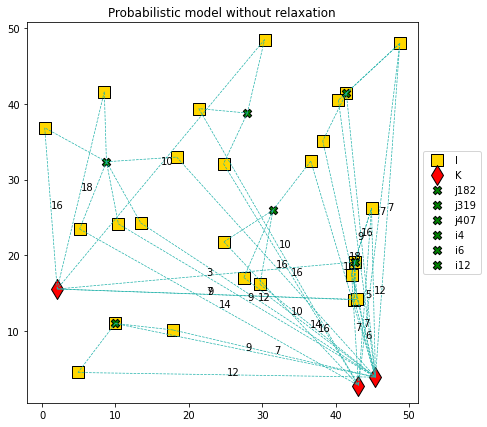

In [40]:
SolutionGraph(I, K, J, model_prob)

Probabilistic model with relaxed constraints

In [41]:
#Redefine set L
L = list()
for k, j in itertools.product(K.index, J.index):
    if dist_KJ[(k, j)] <= B:
        L.append((k, j))
        
L

[('k0', 'j0'),
 ('k0', 'j1'),
 ('k0', 'j2'),
 ('k0', 'j3'),
 ('k0', 'j4'),
 ('k0', 'j5'),
 ('k0', 'j6'),
 ('k0', 'j7'),
 ('k0', 'j8'),
 ('k0', 'j9'),
 ('k0', 'j10'),
 ('k0', 'j11'),
 ('k0', 'j12'),
 ('k0', 'j13'),
 ('k0', 'j14'),
 ('k0', 'j15'),
 ('k0', 'j16'),
 ('k0', 'j17'),
 ('k0', 'j18'),
 ('k0', 'j19'),
 ('k0', 'j20'),
 ('k0', 'j21'),
 ('k0', 'j22'),
 ('k0', 'j23'),
 ('k0', 'j24'),
 ('k0', 'j25'),
 ('k0', 'j26'),
 ('k0', 'j27'),
 ('k0', 'j28'),
 ('k0', 'j29'),
 ('k0', 'j30'),
 ('k0', 'j31'),
 ('k0', 'j32'),
 ('k0', 'j33'),
 ('k0', 'j34'),
 ('k0', 'j35'),
 ('k0', 'j36'),
 ('k0', 'j37'),
 ('k0', 'j38'),
 ('k0', 'j39'),
 ('k0', 'j40'),
 ('k0', 'j41'),
 ('k0', 'j42'),
 ('k0', 'j43'),
 ('k0', 'j44'),
 ('k0', 'j45'),
 ('k0', 'j46'),
 ('k0', 'j47'),
 ('k0', 'j48'),
 ('k0', 'j49'),
 ('k0', 'j50'),
 ('k0', 'j51'),
 ('k0', 'j52'),
 ('k0', 'j53'),
 ('k0', 'j54'),
 ('k0', 'j55'),
 ('k0', 'j56'),
 ('k0', 'j57'),
 ('k0', 'j58'),
 ('k0', 'j59'),
 ('k0', 'j60'),
 ('k0', 'j61'),
 ('k0', 'j62'),
 (

In [42]:
#Redefine sets M_kj

M_kj = {}
M_interim = []

for (k, j) in L:
    for i in I.index:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] <= B:
                M_interim.append(i)
    M_kj[(k, j)] = M_interim
    M_interim = []

M_kj_interim = {key : val for key, val in M_kj.items() if val != []}  

KJ_feas = list(M_kj_interim.keys())
KJ_feas

[('k0', 'j0'),
 ('k0', 'j2'),
 ('k0', 'j3'),
 ('k0', 'j4'),
 ('k0', 'j5'),
 ('k0', 'j6'),
 ('k0', 'j7'),
 ('k0', 'j8'),
 ('k0', 'j9'),
 ('k0', 'j10'),
 ('k0', 'j11'),
 ('k0', 'j12'),
 ('k0', 'j13'),
 ('k0', 'j14'),
 ('k0', 'j15'),
 ('k0', 'j16'),
 ('k0', 'j17'),
 ('k0', 'j19'),
 ('k0', 'j20'),
 ('k0', 'j21'),
 ('k0', 'j22'),
 ('k0', 'j23'),
 ('k0', 'j24'),
 ('k0', 'j25'),
 ('k0', 'j26'),
 ('k0', 'j27'),
 ('k0', 'j28'),
 ('k0', 'j29'),
 ('k0', 'j30'),
 ('k0', 'j31'),
 ('k0', 'j32'),
 ('k0', 'j33'),
 ('k0', 'j34'),
 ('k0', 'j35'),
 ('k0', 'j36'),
 ('k0', 'j37'),
 ('k0', 'j38'),
 ('k0', 'j39'),
 ('k0', 'j40'),
 ('k0', 'j41'),
 ('k0', 'j42'),
 ('k0', 'j43'),
 ('k0', 'j44'),
 ('k0', 'j45'),
 ('k0', 'j46'),
 ('k0', 'j47'),
 ('k0', 'j48'),
 ('k0', 'j49'),
 ('k0', 'j51'),
 ('k0', 'j53'),
 ('k0', 'j54'),
 ('k0', 'j55'),
 ('k0', 'j56'),
 ('k0', 'j57'),
 ('k0', 'j58'),
 ('k0', 'j59'),
 ('k0', 'j60'),
 ('k0', 'j61'),
 ('k0', 'j62'),
 ('k0', 'j63'),
 ('k0', 'j64'),
 ('k0', 'j65'),
 ('k0', 'j66'),
 

In [43]:
#Redefine sets N_i

N_i = {}
N_interim = []

for i in I.index:
    for (k, j) in L:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] <= B:
                N_interim.append((k, j))
    N_i[i] = N_interim
    N_interim = []
    
N_i_interim = {key : val for key, val in N_i.items() if val != []}   
 
I_feas = list(N_i_interim.keys())

In [44]:
#Redefine constants and random variables


I_feasG = []
for i in I_feas:
    for g in range(1, g_i[i] + 1):
        I_feasG.append((i, g))

In [45]:
model_prob_rel = gp.Model('Probabilistic model with relaxation')

x_ikj = model_prob_rel.addVars(I.index, L, vtype = GRB.INTEGER, name = 'x_ikj')
y_j = model_prob_rel.addVars(J.index, vtype = GRB.BINARY, name = 'y_j')
z_ig = model_prob_rel.addVars(IG, vtype = GRB.BINARY, name = 'z_ig')

In [46]:
model_prob_rel.addConstr((gp.quicksum(h_ig[ig] * z_ig[ig] for ig in I_feasG)) >= phi, name = 'c15')
model_prob_rel.addConstrs((gp.quicksum(x_ikj[i, k, j] for (k, j) in N_i[i]) == l_i[i] + gp.quicksum(z_ig) for (i, g) in I_feasG), name = 'c16')
model_prob_rel.addConstrs((gp.quicksum(x_ikj[i, k, j] for i in M_kj[(k, j)]) <= q_j[j] * y_j[j] for (k, j) in KJ_feas), name = 'c17')



model_prob_rel.addConstrs(((dist_JI[(j, i)] + dist_IK[(i, k)]) * y_j[j] <= B
                  for (k, j) in N_i[i] for i in M_kj[(k, j)]), name = 'c18')


model_prob_rel.addConstrs((dist_JI[(j, i)] * y_j[j] <= S for (k, j) in N_i[i] for i in M_kj[(k, j)]), name = 'c20')




Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


{('k0', 'j33', 'i10'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j33', 'i16'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j33', 'i24'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j41', 'i9'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j41', 'i17'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j41', 'i24'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j61', 'i15'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j61', 'i16'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j61', 'i22'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j61', 'i24'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j65', 'i15'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j65', 'i16'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j65', 'i22'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j65', 'i24'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j66', 'i10'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j66', 'i16'): <gurobi.Constr *Aw

In [47]:
model_prob_rel.setObjective(alpha * gp.quicksum(x_ikj) + gp.quicksum(beta[j] * y_j[j] for j in J.index), GRB.MINIMIZE)
model_prob_rel.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 5587 rows, 42708 columns and 7123328 nonzeros
Model fingerprint: 0x48e40660
Variable types: 0 continuous, 42708 integer (3108 binary)
Coefficient statistics:
  Matrix range     [1e-13, 7e+01]
  Objective range  [1e+01, 4e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e+00, 1e+02]
Found heuristic solution: objective 13180.000000
Presolve removed 4092 rows and 37744 columns (presolve time = 5s) ...
Presolve removed 4092 rows and 37744 columns
Presolve time: 5.50s
Presolved: 1495 rows, 4964 columns, 10441 nonzeros
Variable types: 0 continuous, 4964 integer (490 binary)

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.975000e+01   0.000000e+00      6s
    4226 

In [48]:
ListSolution(model_prob_rel)

Number of solutions found: 7
0
5280 
x_ikj[i0,k0,i0] 14
x_ikj[i1,k2,i11] 14
x_ikj[i2,k0,j407] 14
x_ikj[i3,k0,j443] 16
x_ikj[i4,k2,i0] 3
x_ikj[i5,k1,j443] 18
x_ikj[i6,k2,i6] 9
x_ikj[i7,k0,j235] 10
x_ikj[i8,k2,j407] 16
x_ikj[i9,k0,j407] 18
x_ikj[i10,k2,j443] 10
x_ikj[i11,k0,i11] 16
x_ikj[i12,k0,j235] 16
x_ikj[i13,k2,j235] 14
x_ikj[i14,k0,j235] 9
x_ikj[i15,k2,i11] 10
x_ikj[i16,k2,j443] 16
x_ikj[i17,k0,j407] 9
x_ikj[i18,k2,i6] 7
x_ikj[i19,k2,i6] 12
x_ikj[i20,k1,i0] 13
x_ikj[i21,k1,i0] 9
x_ikj[i22,k1,j407] 12
x_ikj[i23,k2,i0] 17
x_ikj[i24,k2,j407] 16
y_j[j235] 1
y_j[j407] 1
y_j[j443] 1
y_j[i0] 1
y_j[i6] 1
y_j[i11] 1


1
5480 
x_ikj[i0,k0,i0] 14
x_ikj[i1,k2,i11] 14
x_ikj[i2,k0,j407] 14
x_ikj[i3,k0,j443] 16
x_ikj[i4,k2,i0] 3
x_ikj[i5,k1,j443] 18
x_ikj[i6,k2,i6] 9
x_ikj[i7,k0,j235] 10
x_ikj[i8,k2,j407] 16
x_ikj[i9,k0,j407] 18
x_ikj[i10,k2,j443] 10
x_ikj[i11,k0,i11] 16
x_ikj[i12,k0,j235] 16
x_ikj[i13,k2,j235] 14
x_ikj[i14,k0,j235] 9
x_ikj[i15,k2,i11] 10
x_ikj[i16,k2,j443] 16
x_ikj[i17,k0,j407] 

In [49]:
SolutionSummary(model_prob_rel)

(      i  Number of drones
 0    i0                14
 1    i1                14
 2   i10                10
 3   i11                16
 4   i12                16
 5   i13                14
 6   i14                 9
 7   i15                10
 8   i16                16
 9   i17                 9
 10  i18                 7
 11  i19                12
 12   i2                14
 13  i20                13
 14  i21                 9
 15  i22                12
 16  i23                17
 17  i24                16
 18   i3                16
 19   i4                 3
 20   i5                18
 21   i6                 9
 22   i7                10
 23   i8                16
 24   i9                18,
       j  Number of drones
 0    i0                56
 1   i11                40
 2    i6                28
 3  j235                49
 4  j407                85
 5  j443                60)

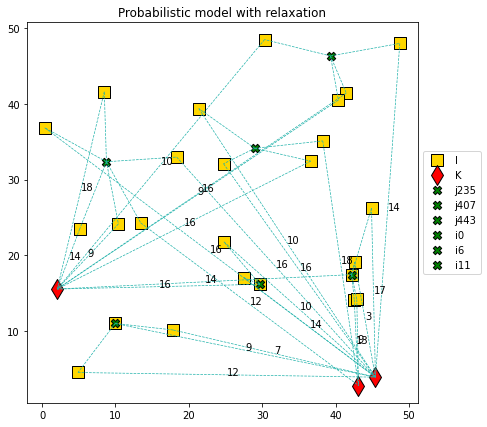

In [50]:
SolutionGraph(I, K, J, model_prob_rel)

Deterministic model with relaxed constraints

In [51]:
model_det_rel = gp.Model('Deterministic model with relaxation')

x_ikj = model_det_rel.addVars(I.index, L, vtype = GRB.INTEGER, name = 'x_ikj')
y_j = model_det_rel.addVars(J.index, vtype = GRB.BINARY, name = 'y_j')

In [52]:
model_det_rel.addConstrs((gp.quicksum(x_ikj[i, k, j] for (k, j) in N_i[i]) >= theta_det[i] for i in I_feas), name = 'c21')
model_det_rel.addConstrs((gp.quicksum(x_ikj[i, k, j] for i in M_kj[(k, j)]) <= q_j[j] * y_j[j] for (k, j) in KJ_feas), name = 'c22')

model_det_rel.addConstrs(((dist_JI[(j, i)] + dist_IK[(i, k)]) * y_j[j] <= B
                  for (k, j) in N_i[i] for i in M_kj[(k, j)]), name = 'c18')

model_det_rel.addConstrs((dist_JI[(j, i)] * y_j[j] <= S for (k, j) in N_i[i] for i in M_kj[(k, j)]), name = 'c25')

model_det_rel.setObjective(alpha * gp.quicksum(x_ikj) + gp.quicksum(beta[j] * y_j[j] for j in J.index), GRB.MINIMIZE)
model_det_rel.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 3031 rows, 40128 columns and 11940 nonzeros
Model fingerprint: 0xe012b360
Variable types: 0 continuous, 40128 integer (528 binary)
Coefficient statistics:
  Matrix range     [4e-01, 7e+01]
  Objective range  [1e+01, 4e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective 11620.000000
Presolve removed 1536 rows and 35165 columns
Presolve time: 0.02s
Presolved: 1495 rows, 4963 columns, 10416 nonzeros
Variable types: 0 continuous, 4963 integer (637 binary)

Root relaxation: objective 2.175058e+03, 4263 iterations, 0.03 seconds (0.05 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/N

In [53]:
ListSolution(model_det_rel)

Number of solutions found: 6
0
3720 
x_ikj[i0,k1,i0] 14
x_ikj[i1,k2,j319] 9
x_ikj[i2,k0,j407] 5
x_ikj[i3,k2,j328] 5
x_ikj[i4,k1,i0] 2
x_ikj[i5,k0,i12] 10
x_ikj[i6,k0,i6] 6
x_ikj[i7,k1,j328] 7
x_ikj[i8,k0,j407] 8
x_ikj[i9,k2,j407] 11
x_ikj[i10,k0,j328] 7
x_ikj[i11,k1,j319] 4
x_ikj[i12,k2,i12] 2
x_ikj[i13,k1,i12] 7
x_ikj[i14,k0,i12] 2
x_ikj[i15,k1,j319] 3
x_ikj[i16,k1,j319] 7
x_ikj[i17,k0,j407] 1
x_ikj[i18,k2,i6] 4
x_ikj[i19,k2,i6] 9
x_ikj[i20,k0,i0] 8
x_ikj[i21,k2,i0] 6
x_ikj[i22,k2,j407] 9
x_ikj[i23,k2,i0] 8
x_ikj[i24,k1,j407] 8
y_j[j319] 1
y_j[j328] 1
y_j[j407] 1
y_j[i0] 1
y_j[i6] 1
y_j[i12] 1


1
4020 
x_ikj[i0,k1,i0] 14
x_ikj[i1,k2,j319] 9
x_ikj[i2,k0,j407] 5
x_ikj[i3,k2,j328] 5
x_ikj[i4,k1,i0] 2
x_ikj[i5,k0,i12] 10
x_ikj[i6,k0,i6] 6
x_ikj[i7,k1,j328] 7
x_ikj[i8,k0,j407] 8
x_ikj[i9,k2,j407] 11
x_ikj[i10,k0,j328] 7
x_ikj[i11,k1,j319] 4
x_ikj[i12,k2,i12] 2
x_ikj[i13,k1,i12] 7
x_ikj[i14,k0,i12] 2
x_ikj[i15,k1,j319] 3
x_ikj[i16,k1,j319] 7
x_ikj[i17,k0,j407] 1
x_ikj[i18,k2,i6] 4
x_ikj[i1

In [54]:
SolutionSummary(model_det_rel)

(      i  Number of drones
 0    i0                14
 1    i1                 9
 2   i10                 7
 3   i11                 4
 4   i12                 2
 5   i13                 7
 6   i14                 2
 7   i15                 3
 8   i16                 7
 9   i17                 1
 10  i18                 4
 11  i19                 9
 12   i2                 5
 13  i20                 8
 14  i21                 6
 15  i22                 9
 16  i23                 8
 17  i24                 8
 18   i3                 5
 19   i4                 2
 20   i5                10
 21   i6                 6
 22   i7                 7
 23   i8                 8
 24   i9                11,
       j  Number of drones
 0    i0                38
 1   i12                21
 2    i6                19
 3  j319                23
 4  j328                19
 5  j407                42)

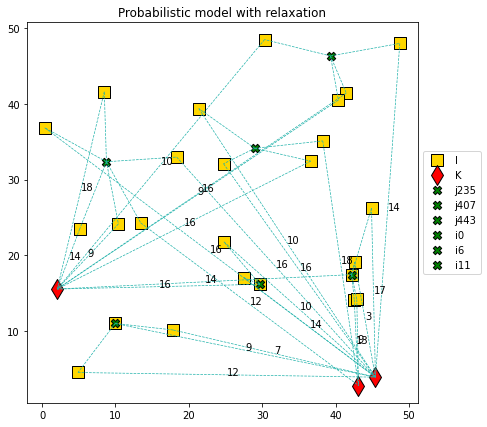

In [55]:
SolutionGraph(I, K, J, model_prob_rel)

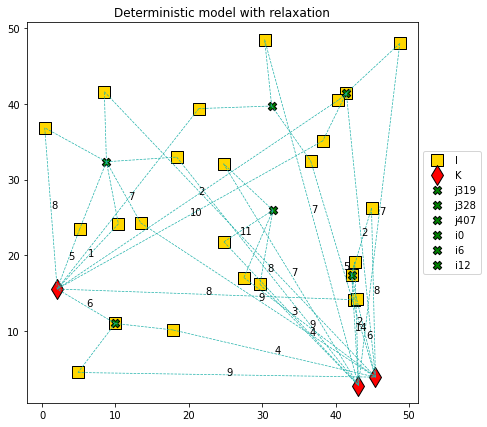

In [56]:
SolutionGraph(I, K, J, model_det_rel)

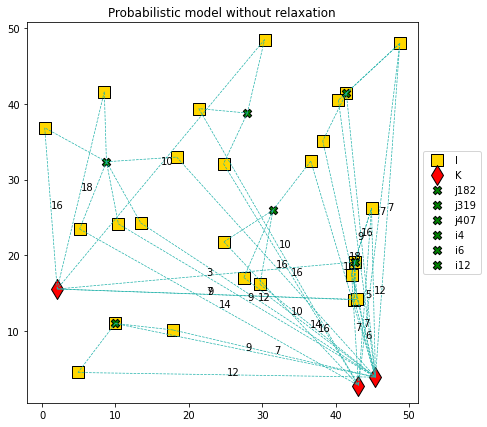

In [57]:
SolutionGraph(I, K, J, model_prob)

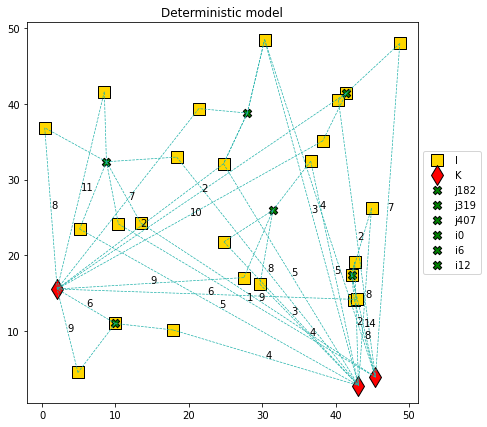

In [58]:
SolutionGraph(I, K, J, model_det)

1) complete information optimum - lower bound for optimum
2) price of uncertainty